# Modelación de flujo de agua subterránea en un medio heterogéneo aleatorio

Script que resuelve la ecuacion de flujo estacionario de Toth
a partir de elemento finito, se agrega un componente estocástico a partir del script en R con la libreria Gstat
Por: Ricardo Balam Chagoya Morales

In [32]:
from __future__ import print_function
from fenics import *
import numpy as np
import random as ra
import sys
import matplotlib.pyplot as plt

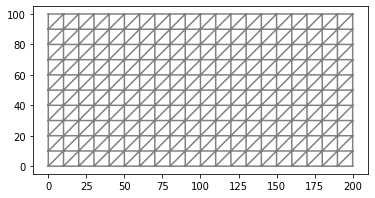

In [33]:
# Se crea la malla donde se define el dominio

mesh= RectangleMesh(Point(0,0),Point(200,100),20,10)
V = FunctionSpace(mesh, 'P', 1)
b=200/20
h=100/10
plt.figure()
plot(mesh)

In [34]:
# Se definen las condiciones de fronteras

def frontera_D(x,frontera):
 tol=1E-14 
 if frontera:
  if abs(x[0]-200)<=tol: 
   return True
  else:
   return False 
 else:
  return False  

def frontera_I(x,frontera):
 tol=1E-14 
 if frontera:
  if abs(x[0])<=tol: 
   return True
  else:
   return False 
 else:
  return False

F_I = DirichletBC(V, Constant(100), frontera_I)
F_D = DirichletBC(V, Constant(10), frontera_D)
bc = [F_I,F_D]

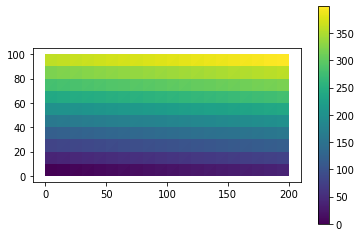

In [35]:
# Se realiza el marcado de la malla
k=range(0,400,1)
subdomains=MeshFunction('size_t',mesh,mesh.topology().dim())
cont=0
for cell in cells(mesh):
 subdomains[cell]=k[cont]
 cont=cont+1

plt.figure()
im1=plot(subdomains)
print(subdomains)
plt.colorbar(im1)

In [36]:
# Se crea un espacio de funciones que simbolizan la conductividad hidráulica   
V0= FunctionSpace(mesh,"DG",0)
k=Function(V0)


In [37]:
# Se asigna para cada valor del marcado un valor del conjunto de conductividades (Los resultados del promedio de la simulación
# no condicional)
#### LAS SIMULACIONES NO CONDICIONALES, ASÍ COMO EL CÁLCULO DE CENTROIDES, FUE GENERADO CON EL ALGORITMO EN R "SImulaciónnocondicional.r"

# Isotropía
ki = np.loadtxt("Isotropo(rango=15).txt",delimiter=',',skiprows=1,usecols=[6])
# Anisotropía Radio = 15 y dirección preferncial horizontal
kah = np.loadtxt("AnisotropoR15(0,0.1).txt",delimiter=',',skiprows=1,usecols=[6])
# Anisotropia Radio= 15 y direción prefencial vertical
ka = np.loadtxt("AnisotropoR15(90,0.1).txt",delimiter=',',skiprows=1,usecols=[6])
k_values=np.exp(ka)
cont=0
for cell_no in cells(mesh):
 subdomain_no=subdomains[cell_no]
 k.vector()[cont]=k_values[subdomain_no]
 cont=cont+1

In [38]:
#Se define el problema variacional

u=TrialFunction(V)
v=TestFunction(V)
f=Constant(0)
a=k*dot(grad(u),grad(v))*dx
g=Constant(0)
L=f*v*dx-g*v*ds

In [39]:
# Se realiza el cálculo de la solución

u= Function(V)
solve(a==L,u,bc)

In [40]:
# Se organizan los valores para la exportación de los datos
#tau=project(grad(u))

tau=project(grad(u))
xx=np.loadtxt("Coordenadascentroide.csv",delimiter=',',skiprows=1,usecols=[1])
yy=np.loadtxt("Coordenadascentroide.csv",delimiter=',',skiprows=1,usecols=[2])
datos=np.zeros((400,7))
datos[:,0]=xx
datos[:,1]=yy
datos[:,4]=k_values

for i in range(0,399):
 datos[i,2]=tau(xx[i],yy[i])[0]
 datos[i,3]=tau(xx[i],yy[i])[1]

datos[:,5]=datos[:,4]*datos[:,2]
datos[:,6]=datos[:,4]*datos[:,3]
np.savetxt("SoluciónFlujo5.1",datos)

Text(0.5, 1.0, 'Conductividad hidraulica (K) - Anisotropia horizontal')

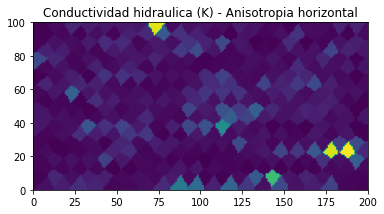

In [43]:
# Ploteo de las conductividades hidráulicas
from scipy.interpolate import griddata

coorx=np.arange(0,200)
coory=np.arange(0,100)

grid_x,grid_y=np.mgrid[0:200,0:100]
coordenadas = datos[:,0:2] 
K=datos[:,4] 
Ti=griddata((datos[:,0],datos[:,1]),datos[:,4],(grid_x,grid_y),method='nearest')

grid_k=griddata(datos[:,0:2],datos[:,4],(grid_x,grid_y),method='nearest')
plt.figure()
plt.imshow(grid_k.T,extent=(0,200,0,100),origin='lower')
plt.title('Conductividad hidraulica (K) - Anisotropia horizontal')

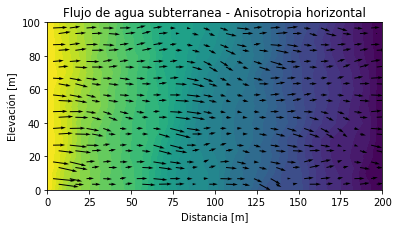

In [44]:
# Ploteo de la solución
plt.figure()
goocarga=plot(u)
flujo=plt.quiver(xx,yy,-datos[:,2],-datos[:,3])
#plt.colorbar(carga)
plt.title('Flujo de agua subterranea')
plt.ylabel('Elevación [m]')
#plt.colorbar(im)
#plot(mesh)
plt.title('Flujo de agua subterranea - Anisotropia horizontal')
plt.ylabel('Elevación [m]')
plt.xlabel('Distancia [m]')
plt.show()
